# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
import csv
import random
from collections import Counter
from utils.textnormalization import TextNormalization
from utils.machinelearning import machine_learning_model, fit_model, metrics_values, confusion_matrix_
from utils.deeplearning import convolutional_neural_network_1d, model_compile, model_fit, evaluate, plot_accuracy_loss, lstm_, gru_
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import go_figure, bar_plot
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
import arabic_reshaper
from bidi.algorithm import get_display
random.seed(40)
tf.random.set_seed(40)

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.drop('clean_txt', inplace=True, axis=1)
Corpus.rename(columns={'sentiment': 'Sentiment', 'txt': 'Review'}, inplace=True)
Corpus.tail(5)

,Sentiment,Review
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...


# Sentiment Information

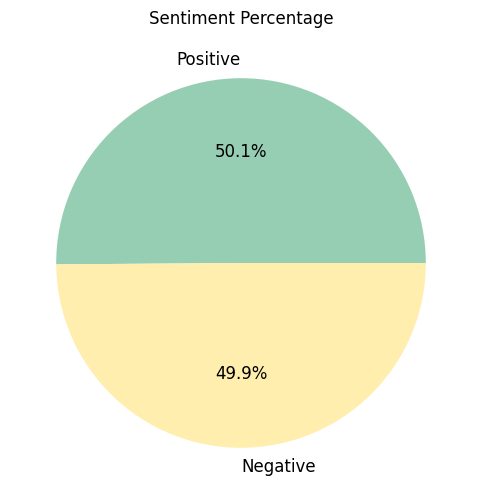

In [5]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

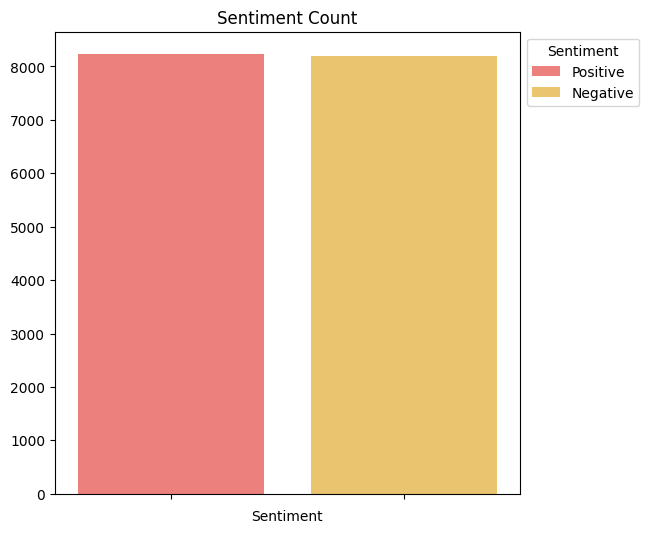

In [6]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [7]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)


In [8]:
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Text Normalization

In [12]:
text_normalization = TextNormalization(_remove_emojis = True,
                                        _remove_hashtags = False,
                                        _remove_emails = False ,
                                        _remove_url = False,
                                        _remove_mention = False,
                                        _remove_duplicate_char = True,
                                        _remove_single_char = True,
                                        _remove_special_character_ = True,
                                        _remove_new_line_char = True,
                                        _remove_number = True,
                                        _remove_html_tags = True,
                                        _remove_arabic_diacritics_ = True,
                                        _normalize_arabic_unicode_ = True,
                                        _normalize_alef_maksura_ar_ = True,
                                        _normalize_alef_ar_ = True,
                                        _normalize_teh_marbuta_ar_ = True,
                                        _remove_non_arabic = True,
                                        _remove_whitespace_ = True,
                                        _remove_unicode_characters_ = True,
                                        _remove_longest_than_ = True,
                                        _remove_stop_words = True,
                                        _lemmatizer_ = False,
                                        _stemmer_ = False)

In [13]:
Corpus['Normalized_Review'] = Corpus['Review'].apply(lambda x: text_normalization.normalization(x))
Corpus.tail(5)

,Sentiment,Review,NumberOfSentences,Normalized_Review
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,الشفقه العطف اقيم الروايه يؤسفني معاناه محمد ش...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,اوصيك بالدقه بالوضوح فاليري ابراهيم اصلان نفذ ...
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,للاسف الشديد يعجبني الكتاب شعرت بالملل الصفحات...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,بدايه الروايه وانا احاول تمالك تعاندني عبرات م...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...,1,خذلتني الروايه يعجبني ابدا تداخل قصتي الكاتب و...


# Number Of Unique Words

In [14]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

76473

# WordCloud

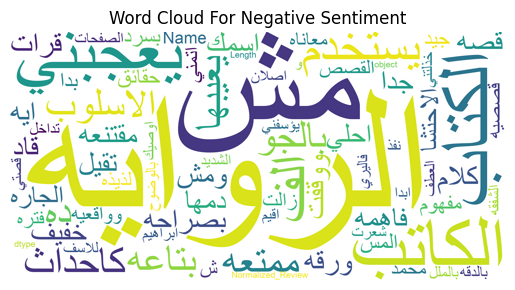

In [15]:
wordcloud(data=Corpus, target='Negative', width=2000, hieght=1000, text='Normalized_Review')

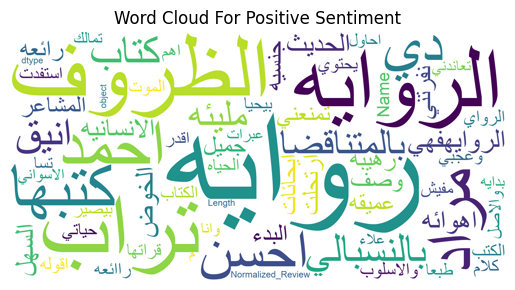

In [16]:
wordcloud(data=Corpus, target='Positive', width=2000, hieght=1000, text='Normalized_Review')

# Most Frequent Words 

In [17]:
MostFrequentWord = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7266
1,الكتاب,6556
2,كتاب,3810
3,روايه,3123
4,الكاتب,2783
5,الله,2301
6,اللي,1875
7,مش,1430
8,رائع,1413
9,الاحداث,1223


In [18]:
go_figure(data=MostFrequentWordDF)

In [19]:
bar_plot(data=MostFrequentWordDF)

# Number Of Words 

In [20]:
Corpus["Number of Words"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

567157

# Number Of Charachters 

In [21]:
Corpus["Number of Charachters"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters"].sum()

3546873

# Average Number Of Words 

In [22]:
AverageNaumberOfWords = int(np.round((Corpus["Number of Words"].mean())))
AverageNaumberOfWords

35

# Average Number Of Charachters 

In [23]:
AverageNumberOfCharachters = int(np.round(Corpus["Number of Charachters"].mean()))
AverageNumberOfCharachters

216

# Maximum Number Of Word

In [24]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [25]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11598

# Minimum Number Of Words

In [26]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [27]:
MinimumNumberOfCharachters = Corpus['Number of Charachters'].min() 
MinimumNumberOfCharachters

3

# Split The Dataset Into X And y

In [28]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']
le = LabelEncoder()
y =le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# CountVectorizer

In [30]:
CountVectorizer_ = CountVectorizer()
X_train_CV_ = CountVectorizer_.fit_transform(X_train)
X_test_CV_ = CountVectorizer_.transform(X_test)

In [31]:
Vocabulary = CountVectorizer_.vocabulary_
Vocabulary

{'سيناريو': 31940,
 'فيلم': 37299,
 'عربي': 34255,
 'ساذج': 30724,
 'فشل': 36464,
 'روايه': 30282,
 'مثيره': 45965,
 'استمتعت': 2591,
 'جيد': 27157,
 'قراءه': 37719,
 'الروايه': 8626,
 'اكره': 4446,
 'البطل': 6112,
 'جاء': 26369,
 'التقييم': 6825,
 'درااما': 28988,
 'ملهاش': 48588,
 'اي': 16156,
 'لازمه': 39858,
 'تعجبني': 24500,
 'ابدا': 146,
 'كتبت': 38664,
 'طريقه': 33510,
 'الخواطر': 8051,
 'غازي': 34988,
 'القصيبي': 11262,
 'اجتر': 806,
 'طوال': 33618,
 'القصه': 11252,
 'مليئه': 48615,
 'بالمعاناه': 17988,
 'والماساه': 54692,
 'يوجد': 65798,
 'احداث': 1108,
 'تشد': 23976,
 'انتباه': 15241,
 'القارئ': 11069,
 'مجرد': 46046,
 'مذكرات': 46639,
 'لمصاب': 43700,
 'بالزهايمر': 17432,
 'اسوا': 2868,
 'قرات': 37739,
 'لغازي': 41782,
 'الاسف': 5073,
 'حاولت': 27323,
 'اتحشي': 381,
 'الكتاب': 11461,
 'لشعوري': 41511,
 'بسيط': 19758,
 'اضطررت': 3254,
 'لقراءته': 41958,
 'بناء': 21042,
 'طلب': 33573,
 'البوك': 6226,
 'كلاب': 39112,
 'اللي': 11849,
 'مشتركه': 47310,
 'كتاب': 38627,
 'خفيف': 28

# Machine Learning

**1-Naive Bayes**

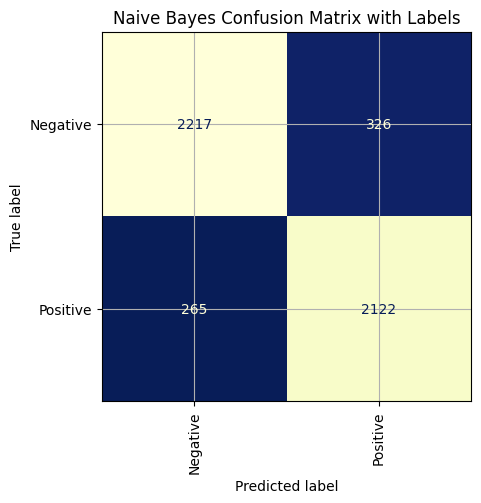

In [32]:
Algorithm = MultinomialNB(alpha= 1)
Naive_Bayes = machine_learning_model(algorithm=Algorithm)
fit_model(model=Naive_Bayes, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Naive_Bayes, X_test=X_test_CV_, y_test=y_test, name='Naive Bayes')

In [33]:
metrics_values(model= Naive_Bayes, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.880122
Precision,0.888982
Recall,0.866830
F1Score,0.877766
Error,0.119878


**2-Logistic Regression**

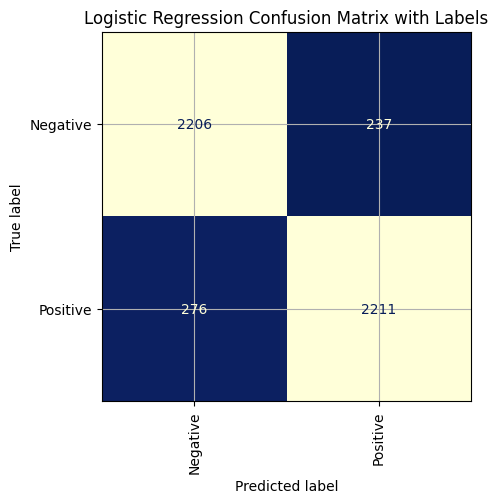

In [34]:
Algorithm = LogisticRegression()
Logistic_Regression = machine_learning_model(algorithm=Algorithm)
fit_model(model=Logistic_Regression, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(Logistic_Regression, X_test=X_test_CV_, y_test=y_test, name='Logistic Regression')

In [35]:
metrics_values(model= Logistic_Regression, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.895943
Precision,0.889023
Recall,0.903186
F1Score,0.896049
Error,0.104057


**3-Decision Tree**

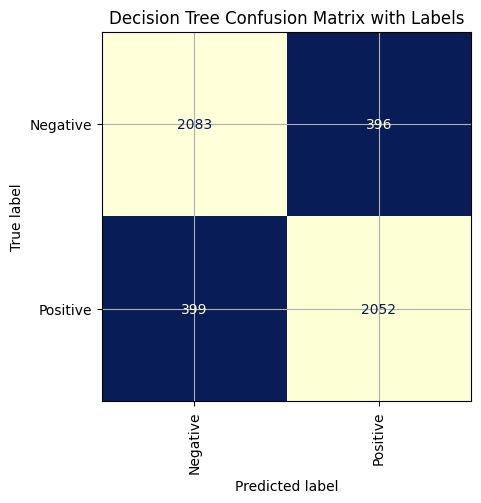

In [36]:
Algorithm = DecisionTreeClassifier(criterion='entropy')
Decision_Tree = machine_learning_model(algorithm=Algorithm)
fit_model(model=Decision_Tree, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Decision_Tree, X_test=X_test_CV_, y_test=y_test, name='Decision Tree')

In [37]:
metrics_values(model= Decision_Tree, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.838742
Precision,0.837209
Recall,0.838235
F1Score,0.837722
Error,0.161258


**4-K Nearest Neighbors**

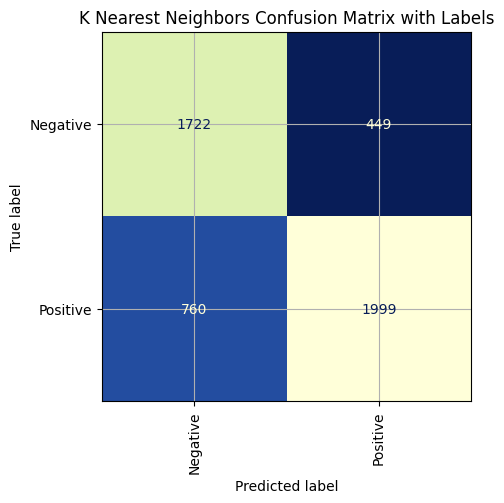

In [38]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
K_Nearest_Neighbors = machine_learning_model(algorithm=Algorithm)
fit_model(model=K_Nearest_Neighbors, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test, name='K Nearest Neighbors')

In [39]:
metrics_values(model= K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.754767
Precision,0.724538
Recall,0.816585
F1Score,0.767813
Error,0.245233


**5-Random Forest**

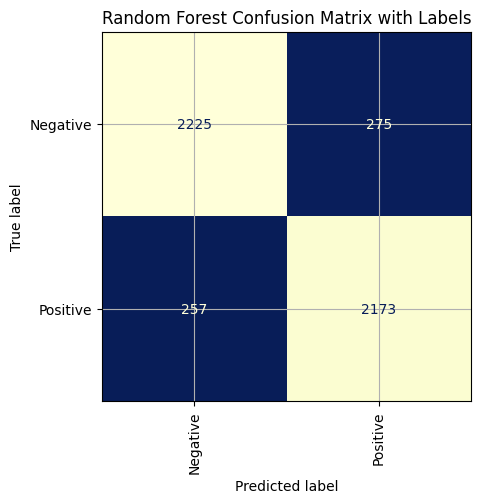

In [40]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
Random_Forest = machine_learning_model(algorithm=Algorithm)
fit_model(model=Random_Forest, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Random_Forest, X_test=X_test_CV_, y_test=y_test, name='Random Forest')

In [41]:
metrics_values(model= Random_Forest, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.892089
Precision,0.894239
Recall,0.887663
F1Score,0.890939
Error,0.107911


**6-SGD Classifier**

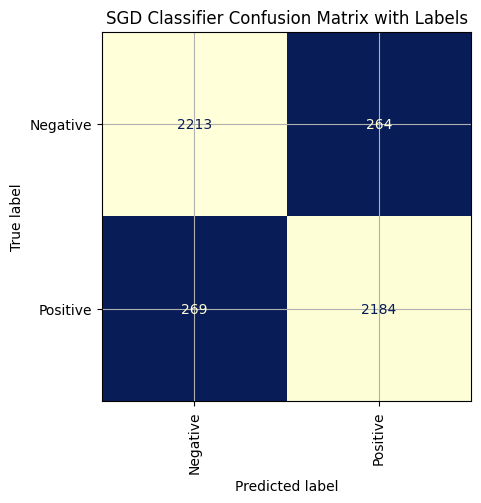

In [42]:
Algorithm = SGDClassifier(loss='hinge')
SGD = machine_learning_model(algorithm=Algorithm)
fit_model(model=SGD, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SGD, X_test=X_test_CV_, y_test=y_test, name='SGD Classifier')

In [43]:
metrics_values(model= SGD, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.891886
Precision,0.890338
Recall,0.892157
F1Score,0.891247
Error,0.108114


**7-Multilayer Perceptron**

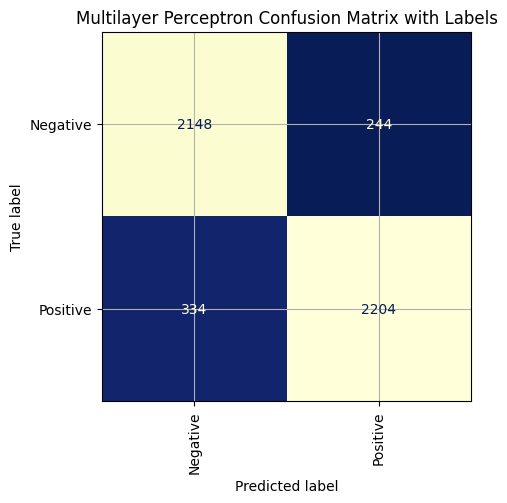

In [44]:
Algorithm = MLPClassifier(hidden_layer_sizes=16)
MLP = machine_learning_model(algorithm=Algorithm)
fit_model(model=MLP, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=MLP, X_test=X_test_CV_, y_test=y_test, name='Multilayer Perceptron')

In [45]:
metrics_values(model= MLP, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.882759
Precision,0.868400
Recall,0.900327
F1Score,0.884075
Error,0.117241


**8-Support Vector Machine**

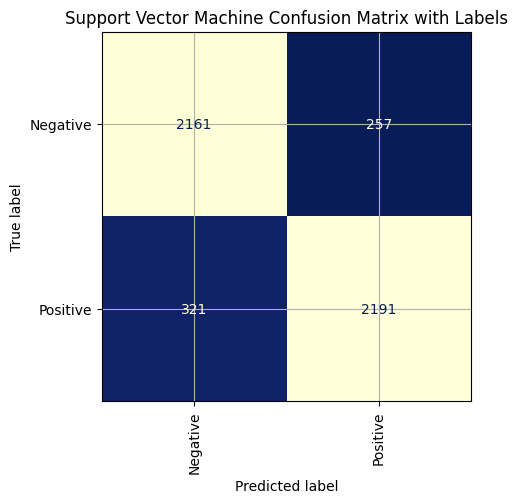

In [46]:
Algorithm = SVC(kernel='linear')
SVM = machine_learning_model(algorithm=Algorithm)
fit_model(model=SVM, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SVM, X_test=X_test_CV_, y_test=y_test, name='Support Vector Machine')

In [47]:
metrics_values(model= SVM, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.882759
Precision,0.872213
Recall,0.895016
F1Score,0.883468
Error,0.117241


# Deep Learning

In [48]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(X_train)
embedding_dim = 16
vocab_size = len(tokenizer.word_index) + 1
vocab_size

65910

In [49]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length =  max([len(x) for x in X_train_seqs])
max_length

1853

In [50]:
encoded_X_train = pad_sequences(X_train_seqs, maxlen=max_length, truncating='pre', padding='pre')
encoded_X_test = pad_sequences(X_test_seqs, maxlen=max_length, truncating='pre', padding='pre')

In [51]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    patience=3
                )

**9-Convolutional Neural Network**

Epoch 1/50
719/719 [==============================] - 126s 170ms/step - loss: 0.6933 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 2/50
719/719 [==============================] - 56s 79ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 3/50
719/719 [==============================] - 38s 53ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 4/50
719/719 [==============================] - 31s 44ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 5/50
719/719 [==============================] - 27s 37ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 6/50
719/719 [==============================] - 23s 32ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 7/50
719/719 [==============================] - 21s 29ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6932 - val_accurac

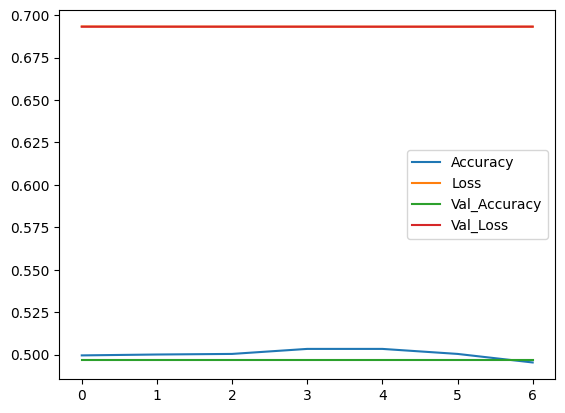

 
The Training Loss is 0.6931, And Training Accuracy is 0.5033
 
The Testing Loss is 0.6932, And Testing Accuracy is 0.4966


In [52]:
convolutional_neural_network = convolutional_neural_network_1d(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, dropout=0.3, kernel=8, filters=32)
model_compile(model=convolutional_neural_network)
history = model_fit(model=convolutional_neural_network, X_train=encoded_X_train, y_train=y_train, epochs=50, X_test=encoded_X_test, y_test=y_test, batch_size=16, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=convolutional_neural_network, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=convolutional_neural_network, x=encoded_X_test, y=y_test, train_test='Testing')

**10-LSTM**

Epoch 1/5
360/360 [==============================] - 144s 377ms/step - loss: 0.5712 - accuracy: 0.7039 - val_loss: 0.4136 - val_accuracy: 0.8122
Epoch 2/5
360/360 [==============================] - 123s 341ms/step - loss: 0.1877 - accuracy: 0.9307 - val_loss: 0.3121 - val_accuracy: 0.8734
Epoch 3/5
360/360 [==============================] - 117s 325ms/step - loss: 0.0721 - accuracy: 0.9760 - val_loss: 0.3281 - val_accuracy: 0.8868
Epoch 4/5
360/360 [==============================] - 99s 276ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.3823 - val_accuracy: 0.8795
Epoch 5/5
360/360 [==============================] - 154s 428ms/step - loss: 0.0160 - accuracy: 0.9945 - val_loss: 0.4540 - val_accuracy: 0.8860


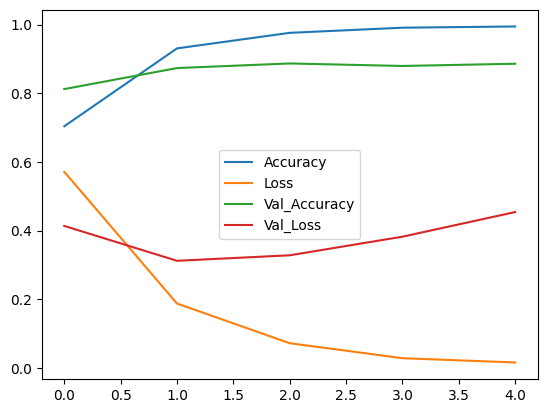

 
The Training Loss is 0.0105, And Training Accuracy is 0.9970
 
The Testing Loss is 0.4540, And Testing Accuracy is 0.8860


In [53]:
LSTM =lstm_(vocab_size= vocab_size, embedding_dim= embedding_dim, max_length= max_length, dropout=0.2, units=64)
model_compile(model=LSTM)
history = model_fit(model=LSTM, X_train=encoded_X_train, y_train=y_train, epochs=5, X_test=encoded_X_test, y_test=y_test, batch_size=32, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=LSTM, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=LSTM, x=encoded_X_test,y= y_test, train_test='Testing')

**11-GRU**

Epoch 1/5
360/360 [==============================] - 177s 467ms/step - loss: 0.5386 - accuracy: 0.7241 - val_loss: 0.3537 - val_accuracy: 0.8438
Epoch 2/5
360/360 [==============================] - 144s 398ms/step - loss: 0.1533 - accuracy: 0.9457 - val_loss: 0.2955 - val_accuracy: 0.8830
Epoch 3/5
360/360 [==============================] - 129s 357ms/step - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.3397 - val_accuracy: 0.8931
Epoch 4/5
360/360 [==============================] - 125s 346ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.4111 - val_accuracy: 0.8925
Epoch 5/5
360/360 [==============================] - 141s 392ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.4583 - val_accuracy: 0.8876


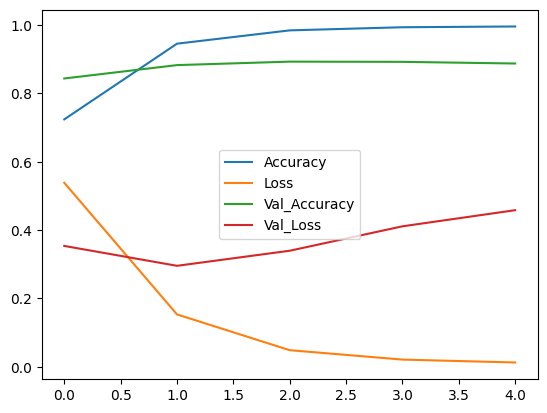

 
The Training Loss is 0.0082, And Training Accuracy is 0.9977
 
The Testing Loss is 0.4583, And Testing Accuracy is 0.8876


In [54]:
GRU_=gru_(vocab_size= vocab_size, embedding_dim= embedding_dim, max_length= max_length, dropout=0.3, units=32)
model_compile(model=GRU_)
history = model_fit(model=GRU_, X_train=encoded_X_train, y_train=y_train, epochs=5, X_test=encoded_X_test, y_test=y_test, batch_size=32, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=GRU_, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=GRU_, x=encoded_X_test,y= y_test, train_test='Testing')